In [1]:
# This code works in Python 3.10.6
import os
import os.path as osp
from typing import Dict, List, Union

import torch
import torch.nn.functional as F
from torch import nn
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import random
import seaborn as sns
import torch_geometric.utils.convert
from torch import optim
from torch_geometric.data import HeteroData

from torch_geometric.nn import HeteroConv, Linear, SAGEConv

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original IMDB dataset with all node features

In [4]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [5]:
def feature_selection_var(X,threshold=0.0):
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    fitted_X = sel.fit_transform(X)
    imp_feat = pd.DataFrame(fitted_X)

    return imp_feat

In [6]:
#all classes
# Feature selection for Movie node
imp_feat = feature_selection_var(data['movie'].x, threshold=0.912)
imp_feat

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
4273,0.0,0.0
4274,0.0,0.0
4275,0.0,0.0
4276,0.0,0.0


In [7]:
data['movie'].x = torch.tensor(imp_feat.values).to(dtype=torch.float32)

Dataset with selected node features used for GNN training

In [8]:
data

HeteroData(
  movie={
    x=[4278, 2],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [9]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py
class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out

def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


In [10]:
import random
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [11]:
#Reading from files, the generated node features using diffusion
class_path = '../../../../../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/discrete_diffusion/imdb/frequency/'

class0  = pd.DataFrame(torch.load(class_path + 'movie0_2feat.pt').cpu().numpy())
class1  = pd.DataFrame(torch.load(class_path + 'movie1_2feat.pt').cpu().numpy())
class2  = pd.DataFrame(torch.load(class_path + 'movie2_2feat.pt').cpu().numpy())
#Download from https://drive.google.com/file/d/1cYWwO4WgfafH3G0bOw69DQsLAFUiJs-5/view in the current folder location and reference the files director_tabddpm.npy, actor_tabddpm.npy as below
tabddpm_path = '../../../../../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/tabddpm/imdb/'

director  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/director_tabddpm.npy',allow_pickle=True))
actor  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/actor_tabddpm.npy',allow_pickle=True))

df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)

In [12]:
actor

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,1.0,0.0,0.0,1.0,0.0,1.0,0.142857,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.666667,0.0,0.000000,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.666667,0.0,0.000000,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.142857,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.666667,3.0,0.333333,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.142857,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,3.0,0.333333,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.666667,0.0,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,0.0,0.0,1.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.666667,3.0,0.000000,0.0
5253,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.666667,3.0,0.000000,0.0
5254,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.666667,0.0,0.333333,0.0
5255,0.0,0.0,1.0,1.0,0.0,1.0,0.142857,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,3.0,0.000000,0.0


In [13]:
director

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.2,0.0,0.000000,1.0,0.00,0.5,1.0,0.0,0.0,0.5,...,0.0,1.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.222222
1,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.222222
2,0.0,1.0,0.000000,0.0,0.00,0.0,1.0,0.5,1.0,0.5,...,0.0,0.0,1.0,0.0,1.0,0.5,0.333333,2.0,0.4,0.222222
3,0.0,0.0,0.333333,1.0,0.00,0.0,1.0,0.5,0.0,0.5,...,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,2.0,0.4,0.000000
4,0.0,0.0,0.000000,1.0,0.25,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.333333,0.0,0.4,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,0.2,0.0,0.000000,0.0,0.25,0.0,1.0,0.0,1.0,0.5,...,0.0,1.0,1.0,1.0,1.0,0.0,0.333333,2.0,0.4,0.222222
2077,0.2,0.0,0.333333,1.0,0.00,0.5,1.0,0.0,1.0,0.5,...,0.0,1.0,1.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.222222
2078,0.2,0.0,0.000000,0.0,0.25,0.5,1.0,0.5,0.0,0.5,...,1.0,0.0,1.0,1.0,0.0,0.5,0.000000,0.0,0.0,0.222222
2079,0.2,0.0,0.000000,1.0,0.25,0.5,1.0,0.0,1.0,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,2.0,0.0,0.000000


In [14]:
def get_node_features(G):
    nodes = []
    director_node_features = []
    movie_node_features = []
    movie_class = []
    actor_node_features = []

    for key, value in G.nodes(data=True):

        nodes.append(key)
        edges = [e for e in G.edges]
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["node_type"]
        if node_type == 0:

            node_id = G.nodes[key]["label"]

            director_node = director.loc[int(node_id), :].values.flatten().tolist()
            director_node_features.append(director_node)
        elif node_type == 2:

            node_class = random.choice([0, 1, 2])

            if node_class == 0:
                
                movie_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(0)
                movie_node_features.append(movie_node)
                
            elif node_class == 1:
                
                movie_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(1)
                movie_node_features.append(movie_node)
                
            elif node_class == 2:
                
                movie_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(2)
                movie_node_features.append(movie_node)

        elif node_type == 1:
   
            actor_node = actor.loc[int(node_id), :].values.flatten().tolist()
            actor_node_features.append(actor_node)


        movie_node_features_df = pd.DataFrame(movie_node_features)
        movie_node_features_df['class'] = movie_class
        director_node_features_df = pd.DataFrame(director_node_features)
        actor_node_features_df = pd.DataFrame(actor_node_features)

    return nodes, edges, movie_node_features_df, director_node_features_df, actor_node_features_df


In [15]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [16]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [17]:
def get_node_type(node_type):
    if node_type == 1:
        return 'actor'
    elif node_type == 0:
        return 'director'
    elif node_type == 2:
        return 'movie'


In [18]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [19]:
def create_dataset(nodes,edges,movie_df,director_df,actor_df,node_id,df_graph):
    movie = np.asarray(movie_df.drop(columns=['class']))
    director = np.asarray(director_df)
    actor = np.asarray(actor_df)
    
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []

    class_dict = {'Director':0, 'Actor':1, 'Movie':2}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Director']):
                movie_to_director.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Actor']):
                movie_to_actor.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Director']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                director_to_movie.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Actor']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            
            
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
            
    actor = list(df_graph[df_graph['class'] == 1]['nodeId'])
    actor = [int(i) for i in actor]
    actor_nodes_mapping = remap_indices(actor)
    
    director = list(df_graph[df_graph['class'] == 0]['nodeId'])
    director = [int(i) for i in director]
    director_nodes_mapping = remap_indices(director)
    
    movie = list(df_graph[df_graph['class'] == 2]['nodeId'])
    movie = [int(i) for i in movie]
    movie_nodes_mapping = remap_indices(movie)

    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})

    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [20]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        small_graph= small_graph.to(device)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)

        return softmax.tolist()

In [21]:
import glob
graphs_path = '../../../../../../../graph generator/diffusion models/sampled_graphs_diffusion/'
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'imdb_5to10/*.gexf')]))

Original no of graphs: 1367


In [22]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [23]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}
    prob_class2_dict = {}
    
    for nodeid in softmax_dict:
        list0= []
        list1= []
        list2= [] 
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
            list2= []   
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
                list2.append(prob[2]) 
    
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:
            prob_class1_dict[nodeid]=max(list1)
        if len(list2) != 0:
            prob_class2_dict[nodeid]=max(list2)
    
    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())
    max_pred2 = max(prob_class2_dict.values())
    
    print('Run'+str(i), max_pred0, max_pred1, max_pred2)
    max_pred_list.append([max_pred0, max_pred1, max_pred2])

    graph_dict_list.append(graph_dict)
    all_edges_list.append(all_edges)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)

    avg_max_pred = (max_pred0+max_pred1+max_pred2)/3
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
    class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
    
    class_graphid_list.append([class0_graphid,class1_graphid,class2_graphid])

In [24]:
for i in range(0,10):   
    
    model = HAN(in_channels=-1, out_channels=3)
    
    device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):  
        loss = train()
        train_acc, val_acc, test_acc = test()
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break
    
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    
    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'imdb_5to10/*.gexf'):
        
        graph = nx.read_gexf(filepath)
        
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
        
        nodeId_list = []
        node_type_list = []
    
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
    
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,movie_node_features,director_node_features,actor_node_features= get_node_features(graph)
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                                  movie_node_features,director_node_features,
                                  actor_node_features,graph_id,df_graph)
        
        edge_list = all_edges[graph_id]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):
        
            if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) and \
                (small_graph_data['movie','to','actor']) and \
                (small_graph_data['movie','to','director']) and \
                (small_graph_data['director','to','movie']):
                
                softmax = evaluate_gnn(small_graph_data)
                softmax_dict[graph_id] = softmax
                nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x,
                                                 'director':small_graph_data['director'].x,
                                                 'actor':small_graph_data['actor'].x}
                graph_dict[graph_id]=df_graph

    print("No. of graphs evaluated: ",len(softmax_dict))

    get_max_pred(softmax_dict,i)

Epoch: 200, Loss: 0.0619, Train: 1.0000, Val: 0.6025, Test: 0.5765
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run0 1.0 0.9999998807907104 0.4513205289840698
Epoch: 200, Loss: 0.0634, Train: 1.0000, Val: 0.6125, Test: 0.5638
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run1 1.0 1.0 0.9999996423721313
Epoch: 200, Loss: 0.0654, Train: 1.0000, Val: 0.6400, Test: 0.5713
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run2 1.0 1.0 1.0
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run3 1.0 0.9999997615814209 0.8943389058113098
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run4 1.0 1.0 0.9999680519104004
Epoch: 200, Loss: 0.0641, Train: 1.0000, Val: 0.6175, Test: 0.5771
Stopping training as validation accuracy did no

In [25]:
avg_max_pred_list

[0.8171068032582601,
 0.9999998807907104,
 1.0,
 0.9647795557975769,
 0.9999893506368002,
 0.9993607997894287,
 0.9990471402804056,
 0.999743382136027,
 0.7763982315858206,
 0.7692275444666544]

In [26]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9325652688741684


In [27]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.09616185888367629


In [28]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

2

In [29]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
              
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)

   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [30]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [31]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [32]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('feature count',fontsize=30)

    plt.show()

In [33]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]

In [34]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]

In [35]:
all_edges = all_edges_list[index]

In [36]:
graph_dict = graph_dict_list[index]

In [37]:
softmax_dict = softmax_dict_list[index]

In [38]:
nodefeature_dict = nodefeature_dict_list[index]

In [39]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graphs and node features for each class of Movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen

Number of nodes:  5
graph id:  graph1
Max pred probability for class 0 is 1.0


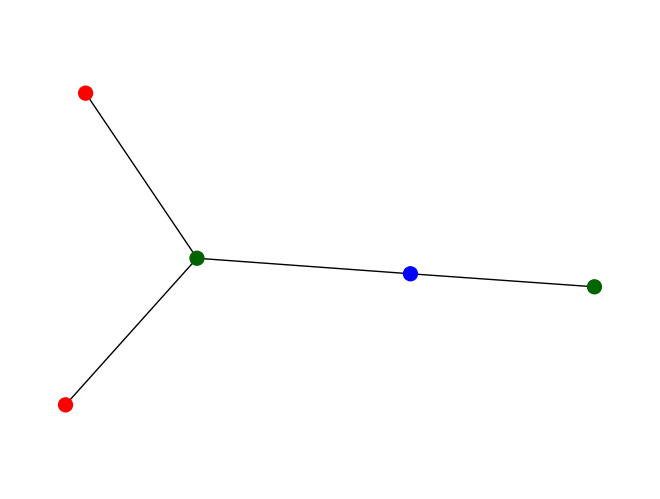

In [40]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [41]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].cpu().numpy()[ind]
Counter(list0)

Counter({2.0: 1, 0.0: 1})

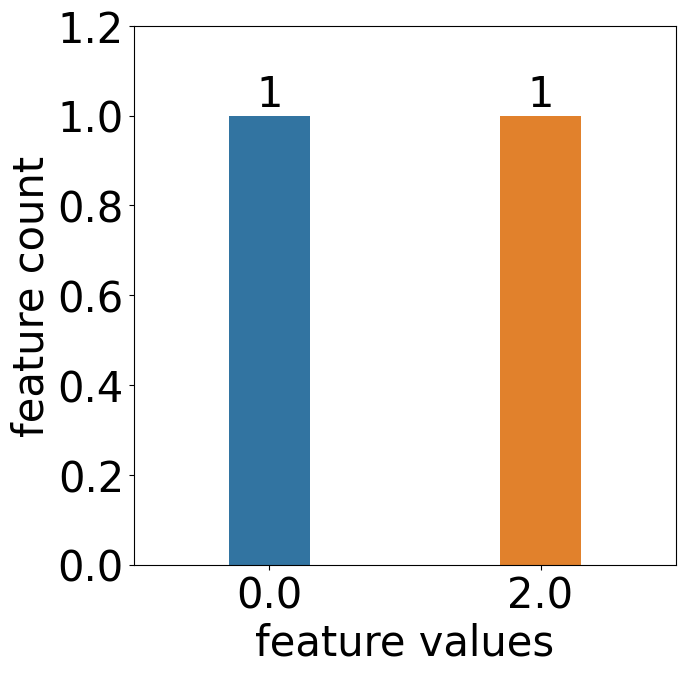

In [42]:
count_plot(list0)

Number of nodes:  10
graph id:  graph1231
Max pred probability for class 1 is 1.0


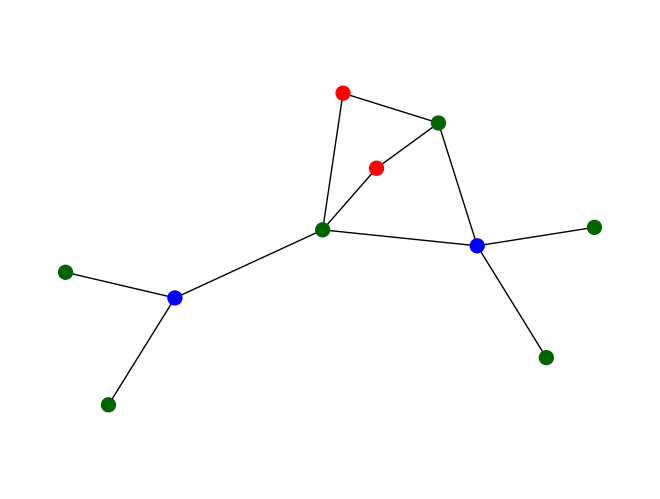

In [43]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [44]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].cpu().numpy()[ind]
Counter(list1)

Counter({2.0: 1, 0.0: 1})

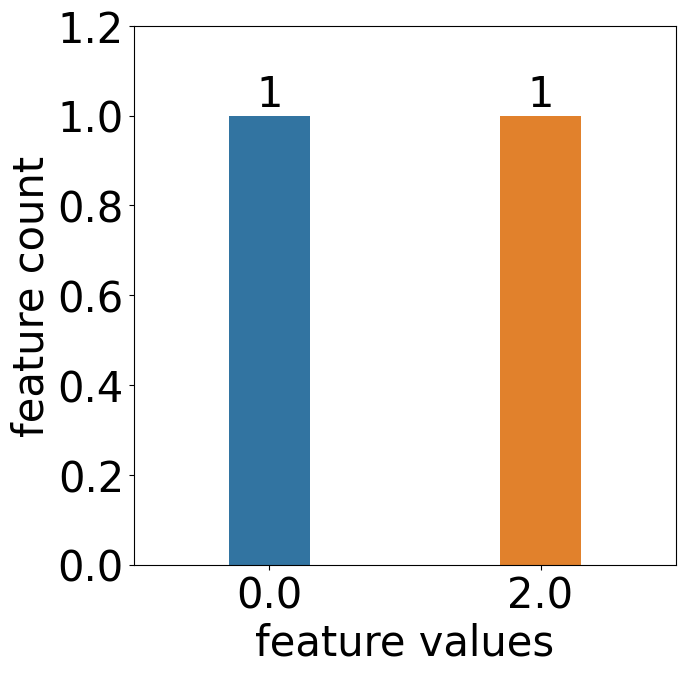

In [45]:
count_plot(list1)

Number of nodes:  9
graph id:  graph1021
Max pred probability for class 2 is 1.0


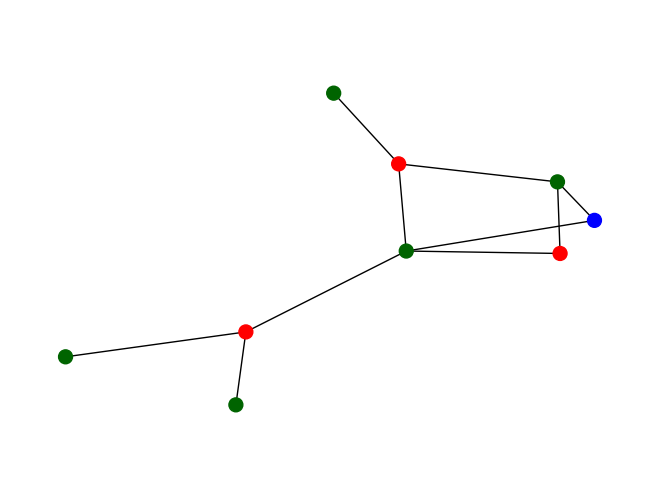

In [46]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [47]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].cpu().numpy()[ind]
Counter(list2)

Counter({5.0: 1, 0.0: 1})

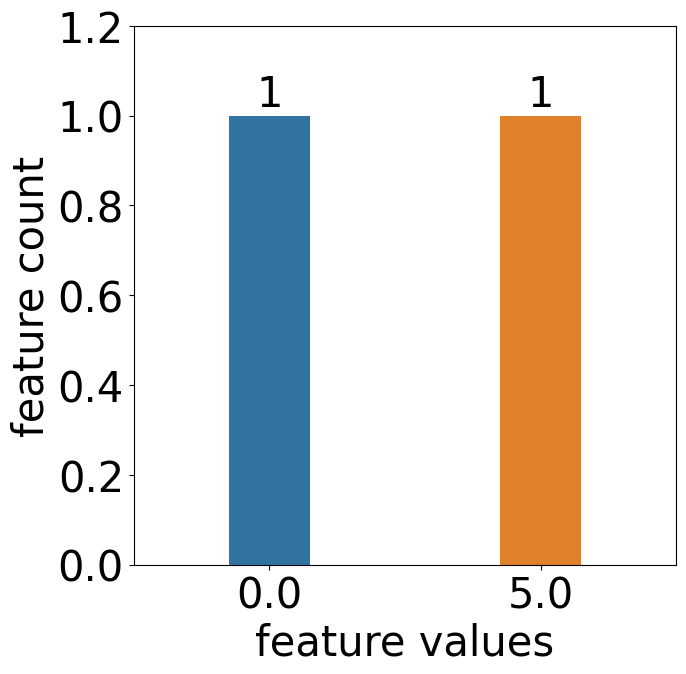

In [48]:
count_plot(list2)

In [49]:
def print_stat_cont_features(df):

    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [50]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [51]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor0_df)

mean 0.5129977
std dev 0.6229172


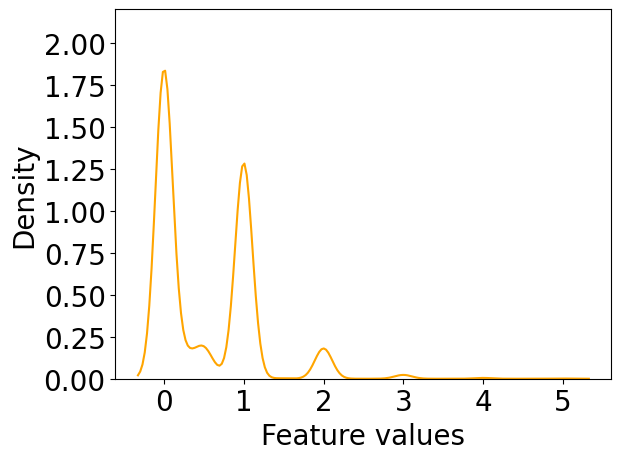

In [52]:
plot_node_feat(actor0_df)

In [53]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor1_df)

mean 0.5182818
std dev 0.6166728


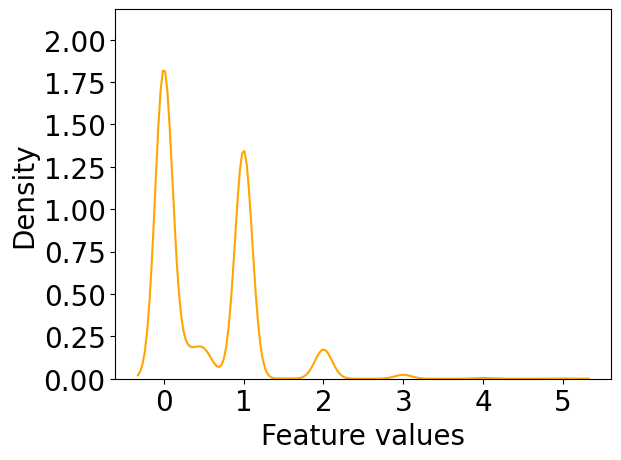

In [54]:
plot_node_feat(actor1_df)

In [55]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor2_df)

mean 0.5063228
std dev 0.6142758


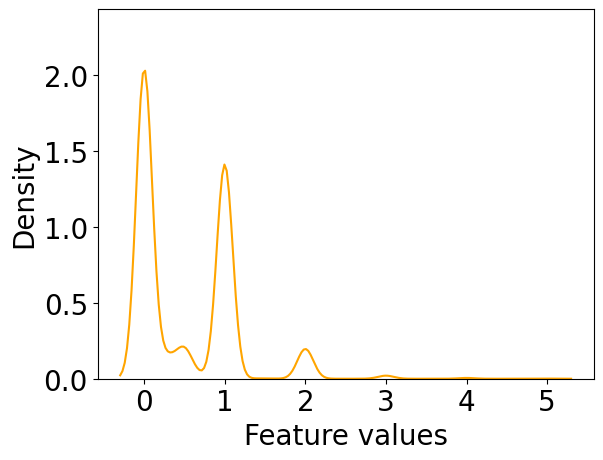

In [56]:
plot_node_feat(actor2_df)

In [57]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].cpu().numpy())
print_stat_cont_features(director0_df)

mean 0.42053652
std dev 0.5728745


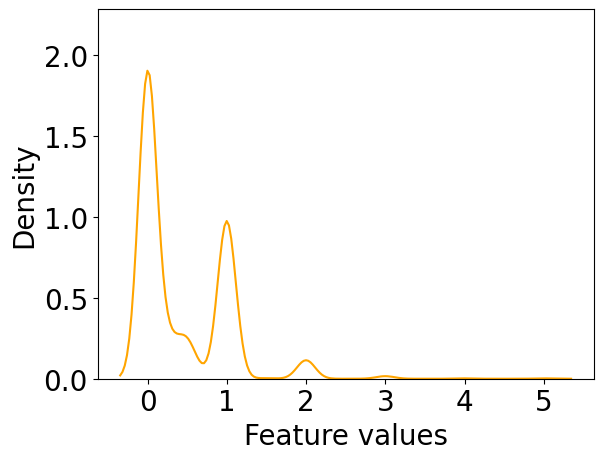

In [58]:
plot_node_feat(director0_df)

In [59]:
director1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['director'].cpu().numpy())
print_stat_cont_features(director1_df)

mean 0.42323345
std dev 0.5582504


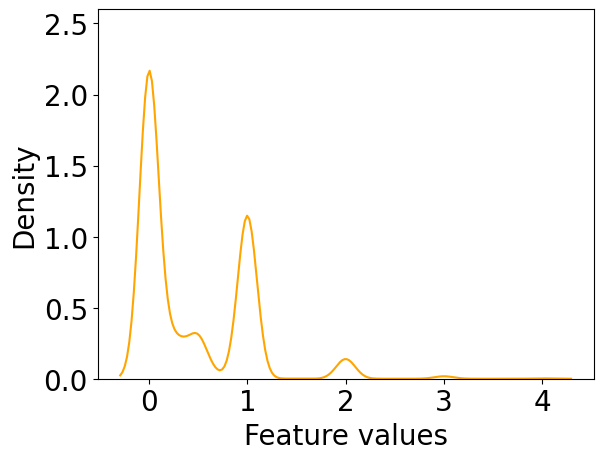

In [60]:
plot_node_feat(director1_df)

In [61]:
director2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['director'].cpu().numpy())
print_stat_cont_features(director2_df)

mean 0.42053652
std dev 0.5728745


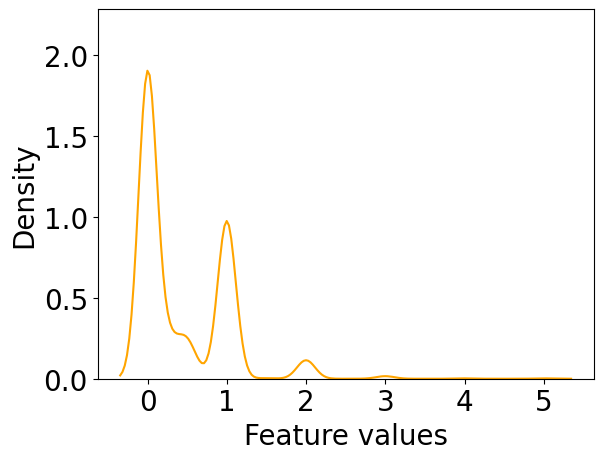

In [62]:
plot_node_feat(director2_df)

In [4]:
motifs_path = '../../../../../common_motifs/imdb_5to10/'
files_motif = os.listdir(motifs_path)

In [5]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../../../common_motifs/imdb_5to10/motif_real_10_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_7_0.gexf
../../../../../common_motifs/imdb_5

In [65]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph = nx.Graph(all_edges[graphid])
        edges = all_edges_list[i][graphid]
        expln_graph = nx.Graph(edges)

        fid_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)
            
            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            fid_score_list.append(x)

        class_faithfulness.append(np.mean(fid_score_list))

    return np.mean(class_faithfulness)

In [66]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.9111111111111111
Run1 0.8555555555555555
Run2 0.9111111111111111
Run3 0.9
Run4 0.8777777777777778
Run5 0.8888888888888888
Run6 0.8555555555555555
Run7 0.9111111111111111
Run8 0.9111111111111111
Run9 0.9222222222222222
Mean 0.8944444444444445


In [67]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.022906142364542567
